In [2]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display
from keras.preprocessing.text import Tokenizer

# Model preprocessing APIs
from sklearn import preprocessing
from sklearn.utils import resample

# Model accuracy plotting APIs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# Model building APIs
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from zipfile import ZipFile

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Set path variables

project_path = '/content/drive/My Drive/Colab/'
file_name ='TempOutput_1.xlsx'

In [5]:
# Import the dataframe

unsampled_df=pd.read_excel(project_path+file_name)
unsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         7909 non-null   int64 
 1   Short description  7909 non-null   object
 2   Description        7906 non-null   object
 3   Assignment group   7909 non-null   object
 4   New Description    7876 non-null   object
 5   Language           7909 non-null   object
 6   Lemmatized clean   7909 non-null   object
dtypes: int64(1), object(6)
memory usage: 432.6+ KB


In [6]:
# Drop columns not needed for Model building

unsampled_df.drop(["Unnamed: 0","Short description", "Description", "Language"],axis=1,inplace=True)

In [7]:
unsampled_df.head(5)

,Assignment group,New Description,Lemmatized clean
0,GRP_0,login issue verified user details employee man...,"['login', 'issue', 'verify', 'user', 'detail',..."
1,GRP_0,outlook received from hmjdrvpb komuaywn team m...,"['outlook', 'receive', 'hmjdrvpb', 'komuaywn',..."
2,GRP_0,cannot log in to vpn received from eylqgodm yb...,"['log', 'vpn', 'receive', 'eylqgodm', 'ybqkwia..."
3,GRP_0,unable to access hr tool page unable to access...,"['unable', 'access', 'hr', 'tool', 'page', 'un..."
4,GRP_0,skype error skype error,"['skype', 'error', 'skype', 'error']"


In [8]:
unsampled_df = unsampled_df.dropna(axis=0)

In [9]:
# Non-Grp_0 dataframe

others_df = unsampled_df[unsampled_df['Assignment group'] != 'GRP_0']

In [10]:
# Get the upper/lower limit to resample

maxOthers = others_df['Assignment group'].value_counts().max()
maxOthers

645

In [11]:
# Upsample the minority classes and downsample the majority classes

df_to_process = unsampled_df[0:0]
for grp in unsampled_df['Assignment group'].unique():
    assign_grp_df = unsampled_df[unsampled_df['Assignment group'] == grp]
    resampled = resample(assign_grp_df, replace=True, n_samples=maxOthers, random_state=123)
    df_to_process = df_to_process.append(resampled)

In [12]:
# Label encode the assignment groups

label_encoder = preprocessing.LabelEncoder() 
  
df_to_process['Assignment group ID']= label_encoder.fit_transform(df_to_process['Assignment group']) 
df_to_process['Assignment group ID'].unique()

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48,
       49, 50, 51, 43, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [13]:
# Function to generate word tokens

def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

In [14]:
# GloVe the dataframe and store the embedding result

glove_file = project_path + "glove.6B.zip"
print(glove_file)

/content/drive/My Drive/Colab/glove.6B.zip


In [15]:
#Extract Glove embedding zip file

with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [16]:
# Perform GloVe embeddings

EMBEDDING_FILE = './glove.6B.100d.txt'
embeddings_glove = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings_glove[word] = embd

In [17]:
results = pd.DataFrame()
predictedResults = pd.DataFrame()

In [18]:
max_len = 300
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(df_to_process["New Description"].values)
X_seq = tokenizer.texts_to_sequences(df_to_process["New Description"].values)
X_padded = pad_sequences(X_seq, maxlen=max_len)

In [19]:
numWords = len(tokenizer.word_index) + 1
epochs = 10
batch_size=100
numWords

12343

In [20]:
# Try the BiLSTM model on the sampled data and predict the accuracy.

tokenizer, X = wordTokenizer(df_to_process['New Description'])
y = np.asarray(df_to_process['Assignment group ID'])
X = pad_sequences(X,maxlen=max_len)

In [21]:
# Create embedding matrix

embedding_matrix = np.zeros((numWords+1,100))

for i,word in tokenizer.index_word.items():
  if i<numWords+1:
    embedding_vector = embeddings_glove.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
# Perform the train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
X_train,X_test,y_train,y_test

(array([[   0,    0,    0, ..., 2523,    4,  391],
        [   0,    0,    0, ...,  106, 1639, 1448],
        [   0,    0,    0, ...,   10,  206,  147],
        ...,
        [   0,    0,    0, ...,   14,   43,   20],
        [   0,    0,    0, ...,  328,   71, 9097],
        [   0,    0,    0, ...,  221,   57,  684]], dtype=int32),
 array([[2134, 2135,   16, ...,  149,    8,  182],
        [   0,    0,    0, ...,    9,  351,  742],
        [   0,    0,    0, ...,  808, 2358,  808],
        ...,
        [   0,    0,    0, ...,   14,   43,   20],
        [   0,    0,    0, ...,    3,    2,  140],
        [   0,    0,    0, ...,   84,   41, 1009]], dtype=int32),
 array([23, 51, 41, ..., 56, 28, 12]),
 array([10, 39, 46, ..., 72, 66,  3]))

In [23]:
# Build the Bi-LSTM model

input_layer = Input(shape=(max_len,),dtype=tf.int64)
embed = Embedding(numWords+1,output_dim=100,input_length=max_len,weights=[embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
lstm=Bidirectional(LSTM(128))(embed)
drop=Dropout(0.3)(lstm)
dense =Dense(100,activation='relu')(drop)
out=Dense((len((pd.Series(y_train)).unique())+1),activation='softmax')(dense)   

model = Model(input_layer,out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

model.summary()
plot_model(model,to_file=project_path + "Bi-LSTM(GloVe)_Sampled_Model.jpg")

checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 100)          1234400   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
Total params: 1,502,171
Trainable params: 1,502,171
Non-trainable params: 0
____________________________________________

In [24]:
# Run the model and get the model history

model_history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_test,y_test))

Epoch 1/10
334/335 [============================>.] - ETA: 0s - loss: 2.2523 - accuracy: 0.4653
Epoch 00001: val_accuracy improved from -inf to 0.72226, saving model to model-001-0.722257.h5
335/335 [==============================] - 22s 64ms/step - loss: 2.2518 - accuracy: 0.4654 - val_loss: 1.0282 - val_accuracy: 0.7223
Epoch 2/10
334/335 [============================>.] - ETA: 0s - loss: 0.7540 - accuracy: 0.7902
Epoch 00002: val_accuracy improved from 0.72226 to 0.85956, saving model to model-002-0.859557.h5
335/335 [==============================] - 21s 63ms/step - loss: 0.7540 - accuracy: 0.7902 - val_loss: 0.5015 - val_accuracy: 0.8596
Epoch 3/10
334/335 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8784
Epoch 00003: val_accuracy improved from 0.85956 to 0.90244, saving model to model-003-0.902437.h5
335/335 [==============================] - 21s 63ms/step - loss: 0.4198 - accuracy: 0.8783 - val_loss: 0.3491 - val_accuracy: 0.9024
Epoch 4/10
334/335 [==

In [25]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
# use argmax per Jason, instead of model.predict_classes if not available. https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
yhat_classes = np.argmax(yhat_probs, axis=1)

In [26]:
# Generate the target label to plot the Confusion Matrix

target_names = df_to_process['Assignment group'].unique()
target_names

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_48', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [27]:
# Generate the Confusion Matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[106   0   1 ...   0   0   0]
 [  0 192   0 ...   0   0   0]
 [  3   0 166 ...   0   0   0]
 ...
 [  0   0   0 ... 172   0   0]
 [  0   4   2 ...   0 111   0]
 [  4   0   0 ...   0   1  56]]


In [28]:
# Generate the Classification Report to print the class level accuracies, here, in the case of multiclass classification.

print('Classification Report')
print(classification_report(y_test, yhat_classes, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       GRP_0       0.77      0.51      0.61       207
       GRP_1       0.89      1.00      0.94       192
       GRP_3       0.98      0.85      0.91       196
       GRP_4       0.98      1.00      0.99       195
       GRP_5       0.97      0.84      0.90       199
       GRP_6       1.00      0.98      0.99       188
       GRP_7       0.99      0.96      0.97       186
       GRP_8       1.00      1.00      1.00       173
       GRP_9       0.97      1.00      0.98       198
      GRP_10       0.99      1.00      1.00       191
      GRP_11       0.98      0.95      0.97       175
      GRP_12       0.97      0.84      0.90       180
      GRP_13       0.83      0.89      0.86       197
      GRP_14       0.99      1.00      1.00       189
      GRP_15       1.00      1.00      1.00       202
      GRP_16       0.98      1.00      0.99       197
      GRP_17       0.98      1.00      0.99       188
     

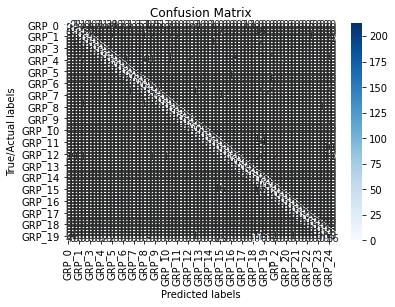

In [29]:
# Plot the Confusion matrix

ax= plt.subplot()
#plt.subplots(figsize=(10,10))
sns.heatmap(matrix,annot=True,ax=ax,cmap='Blues',fmt='d');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True/Actual labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(target_names);
ax.yaxis.set_ticklabels(target_names);

In [30]:
# Summarize the accuracies

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, yhat_classes, average='micro')
print('Precision: %f' % precision)
recall = recall_score(y_test, yhat_classes, average='micro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, yhat_classes,average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.944898
Precision: 0.944898
Recall: 0.944898
F1 score: 0.944898


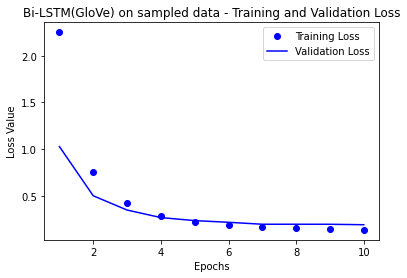

In [31]:
# Plot model losses

loss_values = model_history.history['loss']
val_loss_values = model_history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Bi-LSTM(GloVe) on sampled data - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

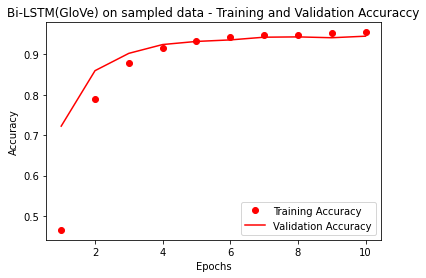

In [32]:
# Plot training and validation accuracies

acc_values = model_history.history['accuracy']
val_acc_values = model_history.history['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'ro', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

plt.title('Bi-LSTM(GloVe) on sampled data - Training and Validation Accuraccy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# Summarize the model history

model_df = pd.DataFrame(model_history.history)
model_df

,loss,accuracy,val_loss,val_accuracy,lr
0,2.251849,0.465386,1.028216,0.722257,0.001
1,0.754033,0.790249,0.501520,0.859557,0.001
2,0.419844,0.878334,0.349133,0.902437,0.001
3,0.281623,0.916285,0.268246,0.924227,0.001
4,0.222347,0.932537,0.236002,0.931909,0.001
5,0.187849,0.942684,0.217934,0.935680,0.001
6,0.167533,0.947652,0.197007,0.942384,0.001
7,0.160648,0.948610,0.197122,0.943152,0.001
8,0.145717,0.952770,0.196685,0.941057,0.001
9,0.136313,0.954656,0.191815,0.944898,0.001


In [ ]:
# Thank you.